In [1]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

try:
    from plotting_CIFAR10 import plot_autoencoder_stats
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`. \
          \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
          \n---------------------------------------------")
    print(ex)

# Unsupservised Learning 

## Labelling Data is Expensive

In supervised machine learning, one aims at learning a mapping $f_{\psi} : \mathbf{x} \in \mathcal{R}^P \rightarrow \mathbf{y}$ from observations $\mathbf{x}$ to the target $\mathbf{y}$ using a dataset $\mathcal{D} = \{\mathbf{x}_i, \mathbf{y}_i\}_{i=1, \dots, N}$ of finite size N (e.g. image classification, translation). Because of the curse of dimensionality, high-dimensional inputs (images) and complex the models (deep learning) require large datasets (million of pairs $(\mathbf{x}, \mathbf{y})$). In practice, labelling data is expensive (e.g. marking the presence of cancer in X-ray chest scans). 

## Compression is Comprehension: Learning without Target

In order to overcome the curse of dimensionality, we aim at learning a compressed representation $\mathbf{z} \in \mathcal{R}^M$ of $\mathbf{x}$ such that $M < P$ and there is a mapping $g_{\phi}: \mathbf{x} \rightarrow \mathbf{z}$ linking each data point to its representation. Ideally, $\mathbf{z}$ is low-dimensional set of features which efficiently describes $\mathbf{x}$. As an illustration, when modelling pictures of celebrities (CelebA dataset), the set of facial features (eye color, age, hair lenth, etc..) is a compressed (and lossy) representation of $\mathbf{x}$. In practice, the representation  $\mathbf{z}$ is unobservable and [unlikely to overlap with such known features](https://arxiv.org/abs/1811.12359). Yet, the representation $\mathbf{z}$ is low dimensional and learning a mapping $f_{\psi} : \mathbf{z} \in \mathcal{R}^M \rightarrow \mathbf{y}$ is often easier.

Whereas labelling the data is expensive, observations $\mathbf{x}$ are cheap to acquire. In many cases, one can scrap the web to gather a large collection of images or text. As a result, large deep learning models can be deployed to learn $g_{\phi}$, and smaller / data-efficient models can be applied downstream to solve the supervised task.



# Auto-encoders: Compression as a Generation Process
In this notebook you will implement a simple auto-encoder (AE). We assume that you are already familiar with the basics of neural networks. We'll start by defining an AE similar to the one used for the finetuning step by [Geoffrey Hinton and Ruslan Salakhutdinov](https://www.cs.toronto.edu/~hinton/science.pdf). We'll experiment with the AE setup and try to run it on the MNIST dataset. There has been a wide variety of research into the field of auto-encoders and the technique that you're about to learn is very simple compared to modern methods: Masked Autoencoders ([MADE](https://arxiv.org/abs/1502.03509), [BERT](https://arxiv.org/abs/1810.04805)), Variational Autoencoders ([VAE](https://arxiv.org/abs/1312.6114), [VQ-VAE](https://arxiv.org/abs/1711.00937), [BIVA](https://arxiv.org/abs/1902.02102), [NVAE](https://arxiv.org/abs/2007.03898)).

In unsupervised learning, we aim at learning compressed representations $\mathbf{z} \in \mathcal{P}$ of $\mathbf{x} \in \mathcal{R}$ where $ M < P$. The architecture of an autoencoder can be decomposed in two steps:

1. *Encoding* $\mathbf{x}$ into a low-dimensional representation $\mathbf{z}$ using a neural network $g_{\phi} : \mathbf{x} \rightarrow \mathbf{z}$.
2. *Decoding* the representation $\mathbf{z}$ into a reconstruction $\hat{\mathbf{x}} = h_\theta(\mathbf{z}) \in \mathcal{R}^P$.

Because $M < P$, the encoding acts as an information bottleneck: only part of the information describing $\mathbf{x}$ can be encoded into $\mathbf{z}$ as long as $M$ is sufficiently small.

Learning the parameters of the autoencoder relies on two aspects:

1. A distance in the observation space $d : \mathcal{R}^{P} \times \mathcal{R}^{P} \rightarrow \mathcal{R}$ (e.g. MSE), measuring the reconstruction quality.
2. Using backpropagation coupled with stochastic gradient descent (SGD) to optimize the parameters $\{\phi, \theta\}$ w.r.t $L := \frac{1}{N} \sum_i d(x_i, h_{\theta}(g_{\phi}(\mathbf{x})))$.

<img src="static/autoencoder.png" />

*The exercises are found at the bottom of the notebook*

## MNIST
First let us load the MNIST dataset and plot a few examples. In this notebook we will use the *dataloaders* and *datasets* provided by PyTorch. Defining the loading of datasets using a dataloader has the advantage that it only load the data that is *neccessary* into memory, which enables us to use very large scale datasets.

We only load a limited amount of classes defined by the `classes` variable to speed up training.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
cuda = torch.cuda.is_available()
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
from functools import reduce

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = True
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.data = new_train_data
    trainset.targets = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.data = new_test_data
    testset.targets = new_test_labels

batch_size = 100
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True)
train_data_iter = iter(train_loader)
test_data_iter = iter(test_loader)
print('used classes:', classes)


'''import torch
cuda = torch.cuda.is_available()

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from functools import reduce

# Flatten the 2d-array image into a vector
flatten = lambda x: ToTensor()(x).view((32**2)*3)

# Define the train and test sets
dset_train = CIFAR10("./", train=True,  transform=flatten, download=True)
dset_test  = CIFAR10("./", train=False, transform=flatten)

class_to_idx = dset_train.class_to_idx

classes = ('cat', 'truck')
classes_idx = np.zeros((len(classes)))

for i, type in enumerate(classes):
    classes_idx[i] = class_to_idx[type]


def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    #(indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    (indices,) = np.where(reduce(lambda x, y: x | y, [np.array(labels) == i for i in classes_idx])) # For CIFAR10
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

batch_size = 64
eval_batch_size = 100
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets))
test_loader  = DataLoader(dset_test, batch_size=eval_batch_size,
                          sampler=stratified_sampler(dset_test.targets))
'''

Files already downloaded and verified
Files already downloaded and verified
used classes: ['cat', 'dog']


'import torch\ncuda = torch.cuda.is_available()\n\nfrom torch.utils.data import DataLoader\nfrom torch.utils.data.sampler import SubsetRandomSampler\nfrom torchvision.datasets import CIFAR10\nfrom torchvision.transforms import ToTensor\nfrom functools import reduce\n\n# Flatten the 2d-array image into a vector\nflatten = lambda x: ToTensor()(x).view((32**2)*3)\n\n# Define the train and test sets\ndset_train = CIFAR10("./", train=True,  transform=flatten, download=True)\ndset_test  = CIFAR10("./", train=False, transform=flatten)\n\nclass_to_idx = dset_train.class_to_idx\n\nclasses = (\'cat\', \'truck\')\nclasses_idx = np.zeros((len(classes)))\n\nfor i, type in enumerate(classes):\n    classes_idx[i] = class_to_idx[type]\n\n\ndef stratified_sampler(labels):\n    """Sampler that only picks datapoints corresponding to the specified classes"""\n    #(indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))\n    (indices,) = np.where(reduce(lambda x, y: x | y,

# Training data
Number of points: 10000
Batch dimension [B x C x H x W]: torch.Size([100, 3, 32, 32])
Number of distinct labels: 2

# Test data
Number of points: 2000
Batch dimension [B x C x H x W]: torch.Size([100, 3, 32, 32])
Number of distinct labels: 2
  dog   cat   dog   dog


'# Plot a batch of MNIST examples\nf, axarr = plt.subplots(4, 16, figsize=(16, 4))\n\n# Load a batch of images into memory\nimages, labels = next(iter(train_loader))\n\nfor i, ax in enumerate(axarr.flat):\n    #ax.imshow(images[i].view(32, 32), cmap="binary_r")\n    r = images[i][0:1024].view(32, 32)\n    g = images[i][1024:1024*2].view(32, 32)\n    b = images[i][1024*2:1024*3].view(32, 32)\n    im = torch.stack((r, g, b), dim=2)\n    ax.imshow(im)\n    #ax.imshow(images[i][0:3072].view(32, 32, 3))\n    ax.axis(\'off\')\n    \nplt.suptitle(\'MNIST handwritten digits\')\nplt.show()'

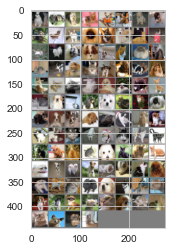

In [3]:
print("# Training data")
print("Number of points:", len(trainset))
x, y = next(iter(train_loader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(trainset.targets)))


print("\n# Test data")
print("Number of points:", len(testset))
x, y = next(iter(test_loader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(testset.targets)))

# Run this cell multiple time to see more samples

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = train_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))



'''# Plot a batch of MNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    #ax.imshow(images[i].view(32, 32), cmap="binary_r")
    r = images[i][0:1024].view(32, 32)
    g = images[i][1024:1024*2].view(32, 32)
    b = images[i][1024*2:1024*3].view(32, 32)
    im = torch.stack((r, g, b), dim=2)
    ax.imshow(im)
    #ax.imshow(images[i][0:3072].view(32, 32, 3))
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()'''

### Building the model
When defining the model the latent layer $z$ must act as a bottleneck of information. We initialize the AE with 1 hidden layer in the encoder and decoder using ReLU units as nonlinearities. The latent layer has a dimensionality of 2 in order to make it easy to visualise. Since $x$ are pixel intensities that are normalized between 0 and 1, we use the sigmoid nonlinearity to model the reconstruction.

In [4]:
import torch.nn as nn
#from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
#from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

# define size variables
num_features = (32**2)*3


# hyperameters of the model
num_classes = 2
channels = 3
height = 32
width = 32
num_filters_conv1 = 5
kernel_size_conv1 = 3 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
num_l1 = 100
padding_conv1 = 0

# Second conv layer
num_filters_conv2 = 8
kernel_size_conv2 = 5
padding_conv2 = 0
stride_conv2 = 1

# Encoder
hE1 = 500
hE2 = 0

# Decoder
hD1 = 500
hD2 = 1000

def compute_conv_dim_uni(dim_size, kernel_size, padding, stride):
    print("conv dim uni", int((dim_size - kernel_size + 2 * padding) / stride + 1))
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)


# First conv layer
conv_out_height = compute_conv_dim_uni(height, kernel_size_conv1, padding_conv1, stride_conv1)
conv_out_width= compute_conv_dim_uni(width, kernel_size_conv1, padding_conv1, stride_conv1)

l1_in_features = num_filters_conv1 * conv_out_height * conv_out_width

class AutoEncoder(nn.Module):
    def __init__(self, latent_features=2):
        super(AutoEncoder, self).__init__()
        # We typically employ an "hourglass" structure
        # meaning that the decoder should be an encoder
        # in reverse.

        # Encoder
        self.conv_encode_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=num_filters_conv1,
                      kernel_size=kernel_size_conv1, stride=stride_conv1),
            nn.ReLU()
        )

        self.lin_encode_block_1 = nn.Sequential(
            nn.Linear(in_features=l1_in_features, out_features=hE1),
            nn.ReLU(),
            # bottleneck layer
            nn.Linear(in_features=hE1, out_features=latent_features)
        )

        # Decoder
        self.lin_decode_block_1 = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hD1),
            nn.ReLU(),
            nn.Linear(in_features=hD1, out_features=hD2),
            nn.ReLU(),
            # output layer, projecting back to image size
            nn.Linear(in_features=hD2, out_features=num_features)
        )

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer

        ## ENCODER ##
        # Convolutional layer 1
        x = self.conv_encode_block_1(x)

        # Change dimensions s.t. the features can be used in the FFNN layer
        x = torch.flatten(x, 1, -1)

        # FFNN layer 1
        z = self.lin_encode_block_1(x)


        ## DECODER ##
        # FFNN layer 1
        x_hat = self.lin_decode_block_1(z)

        # apply sigmoid to output to get pixel intensities between 0 and 1
        x_hat = torch.sigmoid(x_hat)
        
        return {
            'z': z,
            'x_hat': x_hat
        }


# Choose the shape of the autoencoder
net = AutoEncoder(latent_features=100)

if cuda:
    net = net.cuda()

print(net)

conv dim uni 30
conv dim uni 30
AutoEncoder(
  (conv_encode_block_1): Sequential(
    (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (lin_encode_block_1): Sequential(
    (0): Linear(in_features=4500, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=100, bias=True)
  )
  (lin_decode_block_1): Sequential(
    (0): Linear(in_features=100, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=1000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=3072, bias=True)
  )
)


Following we define the PyTorch functions for training and evaluation.

In [5]:
import torch.optim as optim

# if you want L2 regularization, then add weight_decay to SGD
optimizer = optim.SGD(net.parameters(), lr=0.25)

# We will use pixel wise mean-squared error as our loss function
loss_function = nn.MSELoss()

We can test the forward pass by checking whether the output shape is the same as the as the input.

In [6]:
# test the forward pass
# expect output size of [32, num_features]
x, y = next(iter(train_loader))
print(f"x.shape = {x.shape}")

if cuda:
    x = x.cuda()

#outputs = net(x.view(64,3,32,32))
outputs = net(x)
print(f"x_hat.shape = {outputs['x_hat'].shape}")


x.shape = torch.Size([100, 3, 32, 32])
x_hat.shape = torch.Size([100, 3072])


In the training loop we sample each batch and evaluate the error, latent space, and reconstructions on every epoch.

**NOTE** this will take a while on CPU.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4 / 5


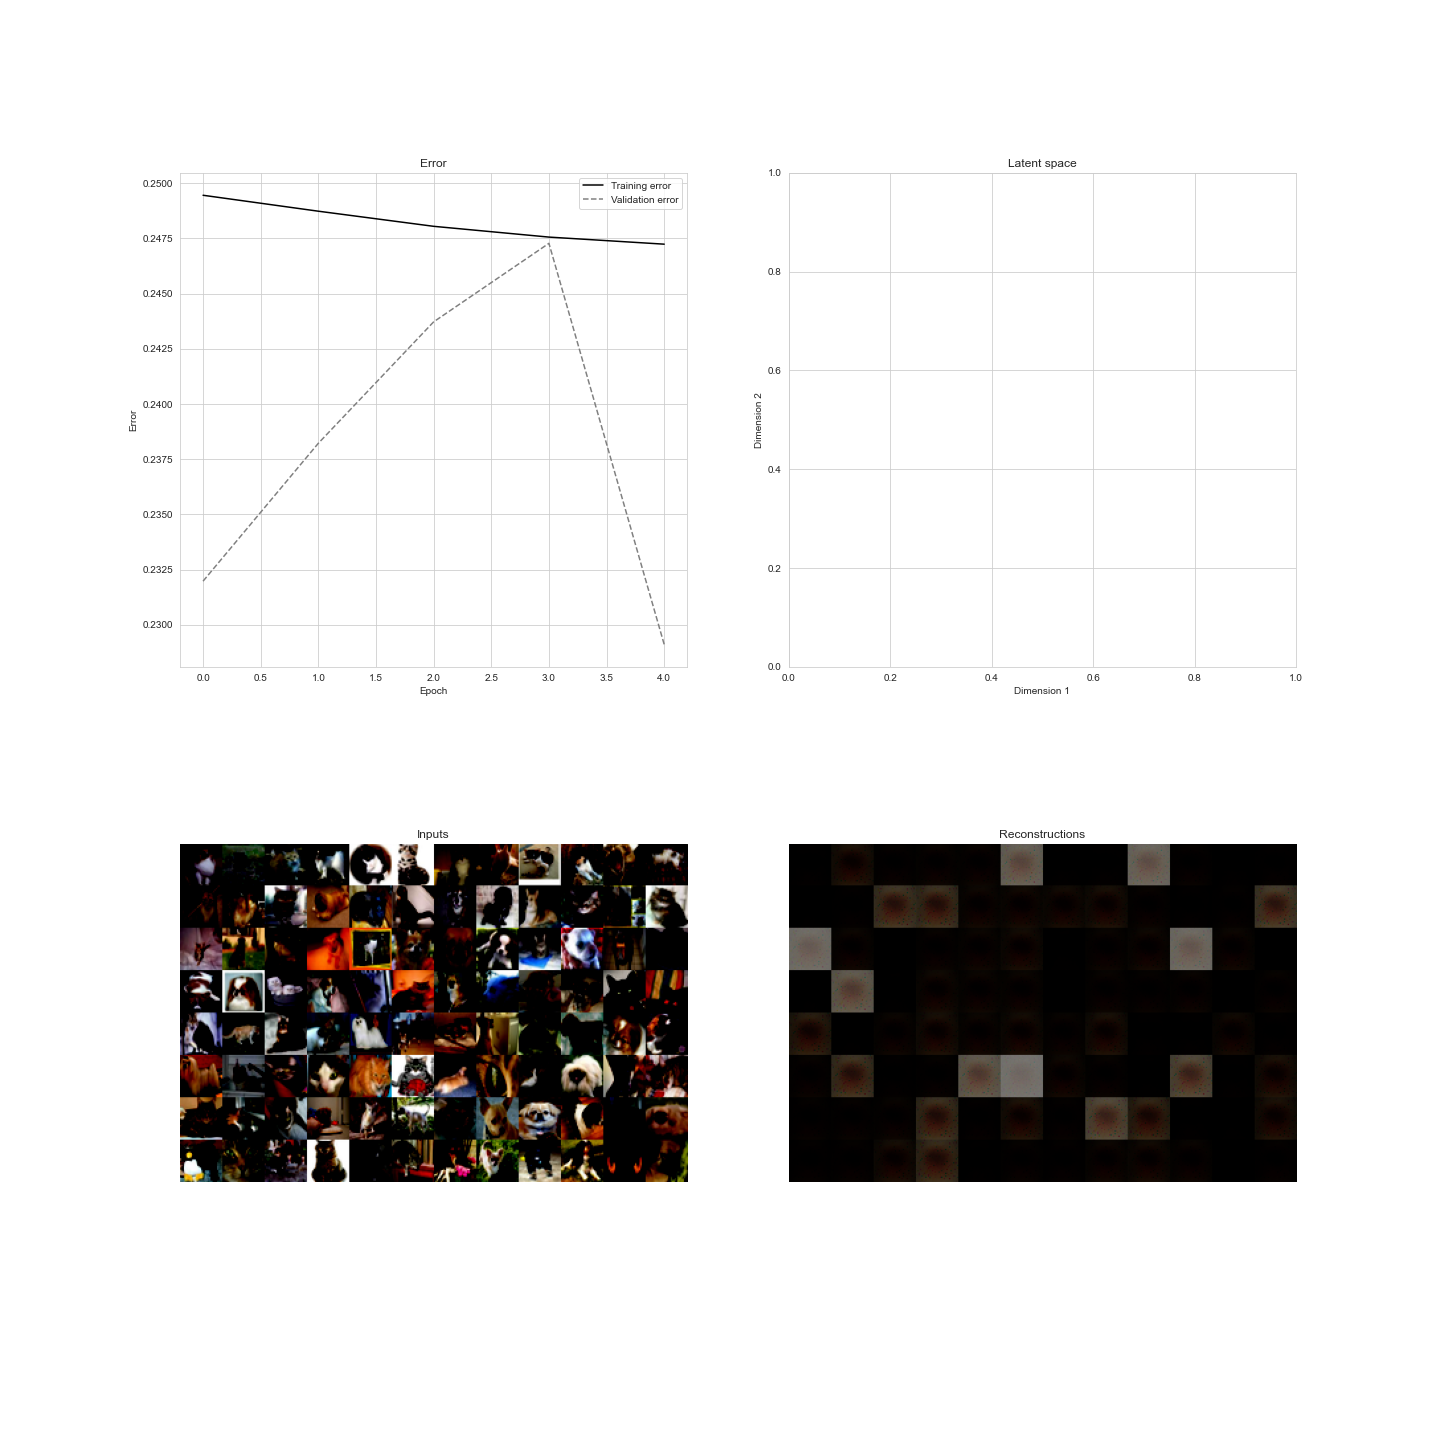

In [9]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

num_epochs = 5

train_loss = []
valid_loss = []
counter = 0
for epoch in range(num_epochs):
    batch_loss = []
    net.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in train_loader:
        
        if cuda:
            x = x.cuda()
        
        outputs = net(x)
        x_hat = outputs['x_hat']

        #if counter == 2499:
        #    print("Hej")
        # note, target is the original tensor, as we're working with auto-encoders
        loss = loss_function(x_hat, x.view(batch_size, width*height*channels))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        counter = counter + 1
        #print("Counter", counter)

    train_loss.append(np.mean(batch_loss))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        
        if cuda:
            x = x.cuda()
        
        outputs = net(x)

        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x_hat = outputs['x_hat']
        z = outputs['z'].cpu().numpy()

        loss = loss_function(x_hat, x.view(batch_size, width*height*channels))

        valid_loss.append(loss.item())
    
    if epoch == 0:
        continue

    print("Epoch", epoch, "/", num_epochs)
    # live plotting of the trainig curves and representation
    plot_autoencoder_stats(x=x.view(batch_size, width*height*channels),
                           x_hat=x_hat,
                           z=z,
                           y=y,
                           train_loss=train_loss,
                           valid_loss=valid_loss,
                           epoch=epoch,
                           classes=classes,
                           dimensionality_reduction_op=None) # = lambda z: TSNE(n_components=2).fit_transform(z)

    
   

# Assignments

## Assignment 1 - Analyzing the AE
1. The above implementation of an AE is very simple.
    - Experiment with the number of layers and try different non-linearities in order to improve the reconstructions
    - What happens with the network when we change the non-linearities in the latent layer (e.g. sigmoid)?
    - Try to increase the number of digit classes in the training set and analyze the results
    - Test different optimization algorithms such as ADAM and RMSProp and decide whether you should use regularizers
       
2. Currently we optimize w.r.t. mean squared error. 
    - Find another error function that could fit this problem better
    - Evaluate whether the similarity function $d$ is a better choice and explain your findings

3. Complexity of the bottleneck.
    - Increase the number of units in the latent layer and train
    - Visualize by using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) or [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

## Assignment 2 - Adding classification for semi-supervised learning

The above training has been performed unsupervised. Now let us assume that we only have a fraction of labeled data points from each class. As we know, semi-supervised learning can be utilized by combining unsupervised and supervised learning. Now you must analyze whether a trained AE from the above exercise can aid a classifier.

1. Build a simple classifier (like the ones from week1) where you:
    - Train on the labeled dataset and evaluate the results
2. Build a second classifier and train on the latent output $\mathbf{z}$ of the AE.
3. Build a third classifier and train on the reconstructions of the AE.
4. Evaluate the classifiers against each other and implement a model that improves the classification by combining the input, latent output, and reconstruction.

Below we provide some starting code for using only a subset of the labelled data.

In [8]:
def uniform_stratified_sampler(labels, classes, n=None):
    """
    Stratified sampler that distributes labels uniformly by
    sampling at most n data points per class
    """
    from functools import reduce
    # Only choose digits in n_labels
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))

    # Ensure uniform distribution of labels
    np.random.shuffle(indices)
    indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in classes])

    indices = torch.from_numpy(indices)
    sampler = SubsetRandomSampler(indices)
    return sampler


batch_size = 64

# Specify how many labelled examples we want per digit class
labels_per_class = 10

# Large pool of unlabelled data
unlabelled = DataLoader(dset_train, batch_size=batch_size, 
                        sampler=stratified_sampler(dset_train.train_labels, classes=classes), pin_memory=cuda)

# Smaller pool of labelled data
labelled = DataLoader(dset_train, batch_size=batch_size,
                      sampler=uniform_stratified_sampler(dset_train.train_labels, classes=classes, labels_per_class),
                      pin_memory=cuda)

SyntaxError: positional argument follows keyword argument (Temp/ipykernel_10076/433074605.py, line 30)

In [ ]:
from itertools import cycle

# This is an example of how you can use both the labelled
# and unlabelled loader in unison

### Define your classifier ###

num_epochs = 100
for epoch in range(num_epochs):
    
    # Go through both labelled and unlabelled data
    for (x, y), (u, _) in zip(cycle(labelled), unlabelled):
        
        if cuda:
            x, y, u = x.cuda(), y.cuda(), u.cuda()
        
        # Send labelled data through autoencoder
        outputs = net(x)

        ### Define your loss function ###
        loss = 0
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()